## **<center>Prueba ML Analyst - Notebook de  modelos/ Machine Learning**</center>

## Introducción:
El objetivo de este análisis es usar datos recopilados sobre llamadas de una campaña  comercial del banco para clasificar nuevas instancias o
llamadas con el fin de detectar si el cliente se suscribirá o no al producto  de depósito  a plazo(aceptan la campaña)y con que probabilidad.

La etiqueta de las instancias es 'suscribed' que puede tomar 2 valores: yes o no, dependiendo de si la persona acepto la campaña y se suscribió al producto o no.

## Pregunta objetivo:
¿Cuál sería la etiqueta de las instancias no clasificadas? , ¿Según los datos  las personas no etiquetadas a las que se contacta se suscribirán o no al producto financiero ofrecido por la campaña?

# Contenido 
1.   Encoding a las variables categoricas
2.   Separando las filas a clasificar
3.   Train test split
4.   Balanceando el dataset con la tecnica SMOTE
5.   Modelos de Machine Learning
6.   Seleccion del mejor modelo.
7.   Seleccion de mejores caracteristicas
8.   Metricas de desempeño del modelo
9.   Matriz de confusión
10.   Evaluacion final del modelo elegido
11.  Guardando el modelo en un archivo JobLib


Importando las librerias necesarias

In [1]:
#Importando las librerias necesarias
import numpy as np
from matplotlib import cm
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from joblib import dump 
from imblearn.over_sampling import SMOTE
import plotly.express as px
import matplotlib as plt


In [2]:
# Cargando el dataset
df=pd.read_csv("../data/processed/bank_campaign_final.csv",index_col=0)

Convirtiendo las columnas categoricas a tipo categorical de python

In [3]:
df['Income']=df['Income'].astype("category")
df['first_contact']=df['first_contact'].astype("category")
cat_cols = list(df.select_dtypes('object').columns)
df[cat_cols]=df[cat_cols].astype('category')



Las columnas previous,campaign,job,education y age son redundantes. En el notebook de eda se explica que a partir del feature engineering  se derivan las columnas first_contact (proxy  colineal de menor cardinalidad para la variable previous), niv_ed (education), campaign_bins(campaign) e Income (Job). Procedemos a eliminar las variables redundantes. 

In [4]:
df.drop(['age','previous','campaign','job','education'],axis=1,inplace=True)

## Aplicando encoding a las variables categoricas:
Se usara la tecnica de OneHotEncoding para las variables categoricas con el fin de que los datos sean procesables por el modelo de ML intentando evitar confundir al algoritmo codificando las categorias como numeros secuenciales y que asi el algoritmo no considere diferencias de magnitud en las categorias que en realidad son inexistentes.

In [5]:
# Creando dataset auxiliar
aux_df = pd.DataFrame(df, columns=['age_range','marital','contact','month','day_of_week','poutcome','campaign_bins','Income','niv_ed','first_contact'])
# Generando dummies
dum_df = pd.get_dummies(df, columns=['age_range','marital','contact','month','day_of_week','poutcome','campaign_bins','Income','niv_ed','first_contact'], prefix=['age_range','marital','contact','month','day_of_week','poutcome','campaign_bins','Income','niv_ed','first_contact'])
# Uniendo dataset auxiliar con dummies
aux_df = aux_df.join(dum_df)
aux_df

,age_range,marital,contact,month,day_of_week,poutcome,campaign_bins,Income,niv_ed,first_contact,...,"campaign_bins_[29, 43)","campaign_bins_[43, 57)",Income_0,Income_1,niv_ed_bachillerato,niv_ed_basica,niv_ed_profesional,niv_ed_sin_educacion,first_contact_0,first_contact_1
0,"[54, 67)",married,telephone,may,mon,nonexistent,"[1, 15)",1,basica,1,...,0,0,0,1,0,1,0,0,0,1
1,"[54, 67)",married,telephone,may,mon,nonexistent,"[1, 15)",1,bachillerato,1,...,0,0,0,1,1,0,0,0,0,1
2,"[28, 41)",married,telephone,may,mon,nonexistent,"[1, 15)",1,bachillerato,1,...,0,0,0,1,1,0,0,0,0,1
3,"[28, 41)",married,telephone,may,mon,nonexistent,"[1, 15)",1,basica,1,...,0,0,0,1,0,1,0,0,0,1
4,"[54, 67)",married,telephone,may,mon,nonexistent,"[1, 15)",1,bachillerato,1,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41167,"[67, 80)",married,cellular,nov,fri,nonexistent,"[1, 15)",1,profesional,1,...,0,0,0,1,0,0,1,0,0,1
41168,"[41, 54)",married,cellular,nov,fri,nonexistent,"[1, 15)",1,profesional,1,...,0,0,0,1,0,0,1,0,0,1
41169,"[54, 67)",married,cellular,nov,fri,nonexistent,"[1, 15)",1,profesional,1,...,0,0,0,1,0,0,1,0,0,1
41170,"[41, 54)",married,cellular,nov,fri,nonexistent,"[1, 15)",1,profesional,1,...,0,0,0,1,0,0,1,0,0,1


Una vez codificadas las variables categoricas, eliminamos las columnas originales que ya hemos codificado para evitar la redundancia.

In [6]:
aux_df.drop(['age_range','marital','contact','month','day_of_week','poutcome','campaign_bins','Income','niv_ed','first_contact'],axis=1,inplace=True)

In [7]:
df=aux_df

## Separando del dataset las filas desconocidas que tenemos como objetivo predecir, en este caso son las 3 ultimas del dataset.


In [8]:
#Guardando aparte las  3 ultimas instancias del dataset  que son las que
# debemos predecir con el modelo que se estimará.
rows_to_predict=df.copy().tail(n=3)
rows_to_predict.to_csv("../data/processed/rows_to_predict.csv")

In [9]:
rows_to_predict

,duration,cons.price.idx,cons.conf.idx,subscribed,"age_range_[15, 28)","age_range_[28, 41)","age_range_[41, 54)","age_range_[54, 67)","age_range_[67, 80)","age_range_[80, 93)",...,"campaign_bins_[29, 43)","campaign_bins_[43, 57)",Income_0,Income_1,niv_ed_bachillerato,niv_ed_basica,niv_ed_profesional,niv_ed_sin_educacion,first_contact_0,first_contact_1
41169,189,94.767,-50.8,NaN,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
41170,442,94.767,-50.8,NaN,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
41171,239,94.767,-50.8,NaN,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0


## Una vez extraidas las columnas que necesitamos tener apartadas para predecir su target, eliminamos estas tres columnas del dataset para el proceso de entrenamiento y modelado.

In [10]:
df.drop(df.tail(3).index,inplace=True)


In [11]:
## Eliminando duplicados despues de la creacion de nuevas variables
df.drop_duplicates(inplace=True)

Aplicando encoding al target del modelo (suscribed)

In [12]:
df['subscribed'].replace(["yes","no"],[1,0],inplace=True)


In [13]:
# Guardando el dataset con las variables categoricas en one-hot-encoding
df.to_csv("../data/processed/df_oh_encoded.csv")

## <center>Machine Learning</center>
* En primer lugar probaremos un modelo simple con el data set desbalanceado y sin normalizar las variables numericas para tener una linea base sobre la cual comparar.

Datos de entrada y de salida

In [14]:
X = df.drop("subscribed", axis=1)
y= df["subscribed"]
print(X.shape,y.shape)

(38725, 45) (38725,)


 **Separando el dataset en entrenamiento y prueba, como el dataset esta desbalanceado es necesario hacer el split estratificado para que conserve la misma proporcion de cada una de las clases objetivo ( en este caso de suscritos y no suscritos al producto financiero) tanto en el dataset de entrenamiento como en el de prueba, esto es importante a la hora de entrenar el modelo y hay que tenerlo en cuenta a la hora de elegir las metricas de desempeño (accuracy, recall, f1, trp, tpp, etc...)**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,random_state =123, stratify=y)

Verificando que el porcentaje de positivos y negativos tanto en el set de entrenamiento como en el de prueba esten en proporcion, en este caso vemos que en ambos sets el porcentaje de positivos es de  11.9 tal y como se espera.

In [16]:
perc_test = y_test.value_counts()[1]*100/len(y_test)
perc_train = y_train.value_counts()[1]*100/len(y_train)

print(f" Porcentaje de positivos en el set de prueba={perc_test} , de entrenamiento={perc_train}")

 Porcentaje de positivos en el set de prueba=11.964193492855912 , de entrenamiento=11.963699413435643


## Se hara una prueba usando la tecnica SMOTE (Synthetic Minority Oversampling Technique) para observar si el modelo mejora o no en el data set balanceado con esta tecnica.

In [17]:
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Metricas de evaluacion
* Para este caso de negocio, es importante para el banco maximizar las subscripciones a los productos financieros que ofrecen las campañas.
Por otra parte cada llamada cuesta dinero, recursos fisicos y humanos y ademas tiempo por lo cual es importante priorizar las llamadas a clientes que tienen una mayor probabilidad de suscribirse al servicio financiero en cuestion.

* En este caso un falso negativo en el modelo podria llevar a no llamar a un potencial suscriptor por un error en el modelo que lo clasificó como un potencial no suscriptor. 
Por otra parte un falso positivo llevaria a clasificar como suscrito a alguien que en realidad no se suscribirá y por tanto llevaría a contactar a personas que se cree que son potenciales suscriptores cuando en realidad no lo son , asumiremos que como desición empresarial este riesgo es mas  aceptable que el primero.

**Teniendo en cuenta lo anterior no se usará el accuracy como métrica de desempeño, en su lugar usaremos recall- sensitivity para evaluar los resultados del modelo.**





# Selección del modelo
Para empezar usaremos modelos tradicionales para tener una linea base para comparar, en este caso usaremos:
* Naive Bayes
* Logistic Regression 
* CART- Clasificador basado en arboles
* Maquina de soporte vectorial

Ademas usaremos kfold cross validation  (con 10 folds ) para seleccionar que modelo se ajusta mejor 

In [18]:
seed =2
models = []

#logistic Regression
models.append(('LR', LogisticRegression(solver='liblinear')))

# Decision Tree classifier
models.append(('CART', DecisionTreeClassifier()))

# Naïve Bayes
models.append(('NB', GaussianNB()))
# SVM
models.append(('SVM', SVC(C=1.0, kernel='rbf', max_iter=1000, tol=1e-3)))
# evaluate each model in turn
results = []
names = []
scoring = 'recall'
for name, model in models:
	# Kfol cross validation for model selection
	kfold = model_selection.KFold(n_splits=10, random_state=None)
	#X train , y train
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = f"({name}, {cv_results.mean()}, {cv_results.std()}"
	print(msg)

(LR, 0.6786865881523081, 0.29273248605211444
(CART, 0.7659984663935937, 0.2106028659148006
(NB, 0.7014389369878018, 0.22617914129724637


/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/niconomist/anacond

(SVM, 0.6302934736896296, 0.08882955735803413


In [19]:
result_df = pd.DataFrame(results, index=names).T
px.box(result_df,title = 'Comparacion de los modelos')

Observamos que con el balanceo de datos el desempeño de todos los modelos empeora.

## Naive Bayes con standard scaler

In [20]:
# Naïve Bayes con standardscaler
NB_pipeline = make_pipeline( StandardScaler(), GaussianNB())
models.append(('NB_pipeline', NB_pipeline))

In [21]:
scoring = 'recall'
name, model
# Kfol cross validation for model selection
kfold = model_selection.KFold(n_splits=10, random_state=None)
#X train , y train
cv_results = model_selection.cross_val_score(NB_pipeline, X_train, y_train, cv=kfold, scoring=scoring)
results.append(cv_results)
names.append('NB_pipeline')
msg = f"({'NB_pipeline'}, {cv_results.mean()}, {cv_results.std()}"
print(msg)

(NB_pipeline, 0.8698838082325079, 0.16110952057422304


In [22]:
result_df = pd.DataFrame(results, index=names).T
px.box(result_df,title = 'Algorithm Comparison')

## Seleccion de caracteristicas usando la funcion selectkbest


In [23]:
X_train

,duration,cons.price.idx,cons.conf.idx,"age_range_[15, 28)","age_range_[28, 41)","age_range_[41, 54)","age_range_[54, 67)","age_range_[67, 80)","age_range_[80, 93)","age_range_[93, 106)",...,"campaign_bins_[29, 43)","campaign_bins_[43, 57)",Income_0,Income_1,niv_ed_bachillerato,niv_ed_basica,niv_ed_profesional,niv_ed_sin_educacion,first_contact_0,first_contact_1
0,53,93.994000,-36.400000,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,351,92.893000,-46.200000,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2,149,93.918000,-42.700000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
3,176,93.075000,-47.100000,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,59,92.893000,-46.200000,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47723,712,94.032297,-50.494510,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47724,273,93.112061,-34.457414,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
47725,625,93.918000,-42.700000,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
47726,261,94.179878,-37.588937,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [24]:
## Seleccionando las mejores 30 caracteristicas
selector = SelectKBest(score_func=chi2, k=30)

selector.fit(X_train.drop("cons.conf.idx",axis=1),y_train)

vector_names = list(X_train.drop("cons.conf.idx",axis=1).columns[selector.get_support(indices=True)])
print(vector_names)

['duration', 'age_range_[15, 28)', 'age_range_[28, 41)', 'age_range_[41, 54)', 'age_range_[54, 67)', 'marital_divorced', 'marital_married', 'marital_single', 'contact_cellular', 'contact_telephone', 'month_aug', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'campaign_bins_[15, 29)', 'niv_ed_bachillerato', 'niv_ed_basica', 'niv_ed_profesional', 'first_contact_0', 'first_contact_1']


In [25]:
#Set de entrenamiento con las mejores 30 caracteristicas.
X_train_filtered=X_train[['duration', 'age_range_[15, 28)', 'age_range_[28, 41)', 'age_range_[41, 54)', 
'age_range_[54, 67)', 'age_range_[67, 80)', 'age_range_[80, 93)', 'age_range_[93, 106)', 'marital_married', 
'marital_single', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_dec', 'month_jul', 'month_mar', 
'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'poutcome_failure', 'poutcome_nonexistent', 
'poutcome_success', 
'campaign_bins_[15, 29)', 'Income_0', 'niv_ed_basica', 'niv_ed_profesional', 'first_contact_0', 'first_contact_1']]


## Seleccionando modelo una vez mas, esta ves con el dataset filtrado con sus mejores 30 caracteristicas

In [26]:
seed =2
models = []

#logistic Regression
models.append(('LR', LogisticRegression(solver='liblinear')))

# Decision Tree classifier
models.append(('CART', DecisionTreeClassifier()))

# Naïve Bayes
models.append(('NB', GaussianNB()))
# SVM
models.append(('SVM', SVC(C=1.0, kernel='rbf', max_iter=1000, tol=1e-3)))
# evaluate each model in turn
results = []
names = []
scoring = 'recall'
for name, model in models:
	# Kfol cross validation for model selection
	kfold = model_selection.KFold(n_splits=10, random_state=None)
	#X train , y train
	cv_results = model_selection.cross_val_score(model, X_train_filtered, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = f"({name}, {cv_results.mean()}, {cv_results.std()}"
	print(msg)

(LR, 0.7150731609070529, 0.21724836301829284
(CART, 0.7519583924700063, 0.21776905803220542
(NB, 0.6875959979910309, 0.16108524227451804


/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/svm/_bas

(SVM, 0.6070665451338433, 0.0958810661616098


In [27]:
result_df = pd.DataFrame(results, index=names).T
px.box(result_df,title = 'Comparacion de los modelos')

## Cart con standar scaler 

In [28]:
# Naïve Bayes con standardscaler
CART_pipeline = make_pipeline( StandardScaler(), DecisionTreeClassifier())
models.append(('NB_pipeline', NB_pipeline))

In [29]:
scoring = 'recall'
name, model
# Kfol cross validation for model selection
kfold = model_selection.KFold(n_splits=10, random_state=None)
#X train , y train
cv_results = model_selection.cross_val_score(CART_pipeline, X_train_filtered, y_train, cv=kfold, scoring=scoring)
results.append(cv_results)
names.append('CART_pipeline')
msg = f"({'CART_pipeline'}, {cv_results.mean()}, {cv_results.std()}"
print(msg)

(CART_pipeline, 0.7481422683938173, 0.22199546867383588


In [30]:
result_df = pd.DataFrame(results, index=names).T
px.box(result_df,title = 'Algorithm Comparison')

## Conclusiones del primer modelado
Se verifica que con la tecnica SMOTE No se obtienen buenos resultados debido que aumenta mucho la varianza y no se ajustan bien los modelos por lo tanto se usará el modelo original obtenido con los datos desbalanceados

## Optimizacion de hiperparametros  del modelo GaussianNB

Para optimizar los hiperparametros revisaremos si el modelo GaussianNB se comporta de una mejor manera buscando mejores hiperparametros.

Los resultados muestran que la informacion captada por el modelo es muy similar tanto si se sabe como si no se sabe la distribucion a priori de la variable subscribed.

In [31]:
#distribucion a priori de las clases
y.value_counts()/len(y)
a,b = y.value_counts()/len(y)
parameters = {'priors': [None, [a,b]]}

grid_search = GridSearchCV(GaussianNB(), parameters, cv=10, return_train_score=True)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'priors': None}

## <center>Evaluación final del modelo en el set de prueba (X_test,y_test).</center>

# Evaluando Naive Bayes simple

In [32]:
#Evaluando modelo Naive Bayes simple 
NB = GaussianNB()
NB.fit(X_train,y_train)
y_pred = NB.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10228
           1       0.48      0.46      0.47      1390

    accuracy                           0.87     11618
   macro avg       0.70      0.70      0.70     11618
weighted avg       0.87      0.87      0.87     11618



/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



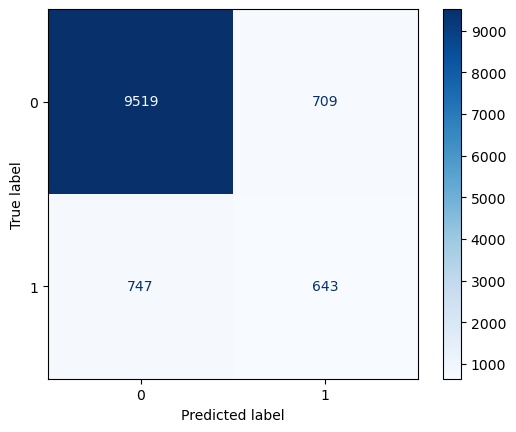

In [34]:
plot_confusion_matrix(NB, X_test, y_test,cmap=plt.cm.Blues); 

In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp+fn)
print (f'La metrica de sensibilidad del modelo es {sensitivity}')

La metrica de sensibilidad del modelo es 0.46258992805755395


In [36]:
Negative_predictive_value = tn /(tn+fn)
print(f'la capacidad de prediccion para los casos negativos es {Negative_predictive_value}')

la capacidad de prediccion para los casos negativos es 0.9272355347749854


## Evaluando NaiveBayes con standardScaler
**Al evaluar el modelo Naive Bayes con las predicciones en el set balanceadi de prueba, vemos que no se obtiene una mejora
significativa en los resultados, por el contrario aumenta la varianza  calculada mediante cross validation y el recall para la clase 0 disiminuye.**


**Por lo tanto el modelo elegido para predecir los casos faltantes sera el NaiveBayes con standard scaler y datos desbalanceados**



In [37]:
NB_pipeline.fit(X_train,y_train)
y_pred = NB_pipeline.predict(X_test)


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.54      0.69     10228
           1       0.19      0.81      0.31      1390

    accuracy                           0.57     11618
   macro avg       0.57      0.67      0.50     11618
weighted avg       0.86      0.57      0.65     11618



/home/niconomist/anaconda3/envs/sklearn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



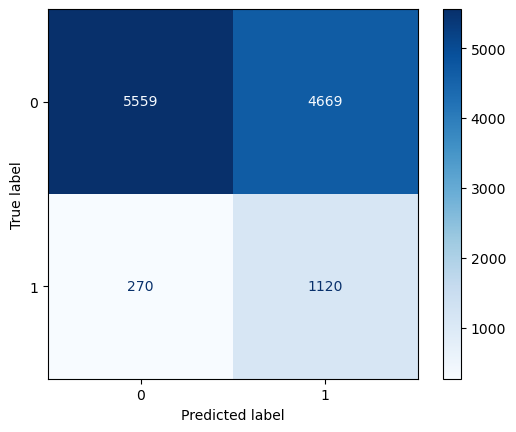

In [39]:
plot_confusion_matrix(NB_pipeline, X_test, y_test,cmap=plt.cm.Blues); 

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp+fn)
sensitivity

0.8057553956834532

In [41]:
Negative_predictive_value = tn /(tn+fn)
Negative_predictive_value

0.9536798764796706

## Guardando el modelo

In [42]:
dump(NB_pipeline, '../models/NB_balanced_recall.joblib')

['../models/NB_balanced_recall.joblib']

## Conclusiones finales


Se logra un modelo razonablemente bueno mediante el uso del algoritmo NaiveBayes con standardScaler y sin balancear los datos, sin embargo es necesario probar con otras alternativas de ser necesario .

EL modelo final que usaremos para la prediccion de las instancias no clasificadas sera NaiveBayes con standard scaler y datos desbalanceados.


## Referencias

https://sitiobigdata.com/2019/01/19/machine-learning-metrica-clasificacion-parte-3/

https://towardsdatascience.com/dealing-with-categorical-variables-by-using-target-encoder-a0f1733a4c69

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

Autor : 
**Nicolas Restrepo Carvajal** 

https://www.linkedin.com/in/niconomist98/

https://github.com/niconomist98



